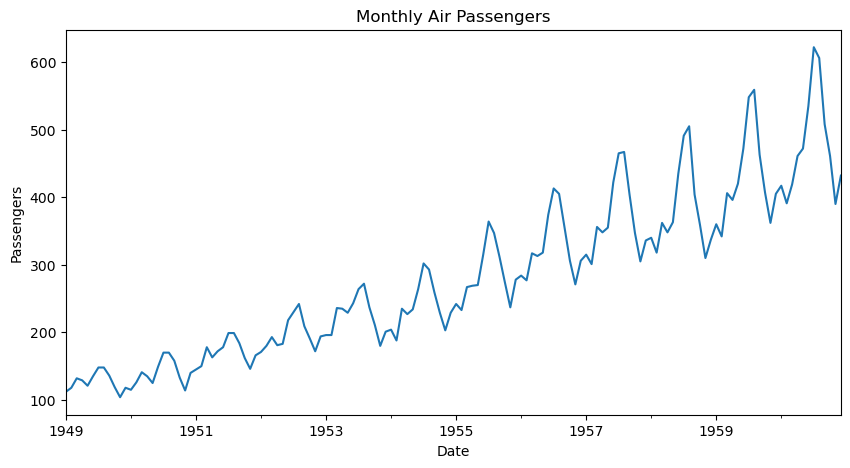

=== ADF Test on Original Series ===
ADF Statistic: 0.8153688792060472
p-value: 0.991880243437641
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Result: Non-stationary — Differencing needed


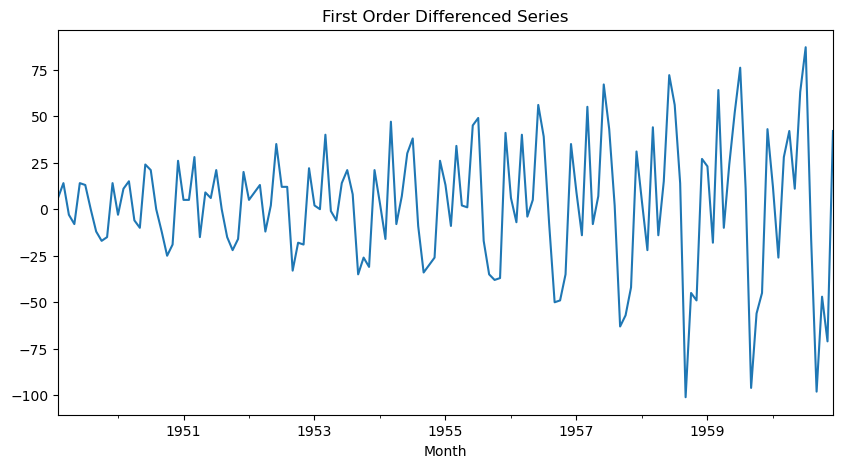


=== ADF Test After First Differencing ===
ADF Statistic: -2.8292668241700056
p-value: 0.054213290283824704
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Result: Non-stationary — Differencing needed


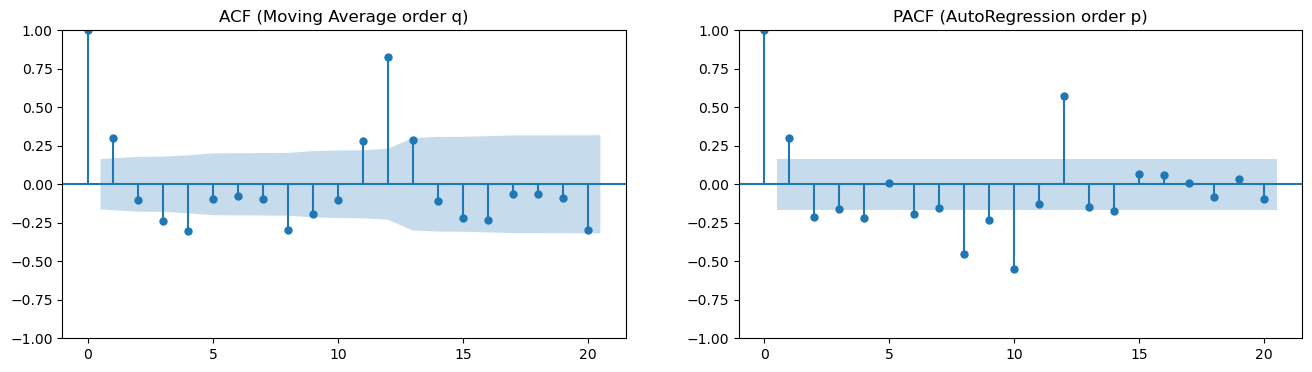

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Tue, 27 May 2025   AIC                           1353.347
Time:                        16:16:37   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.421      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.879      0.0

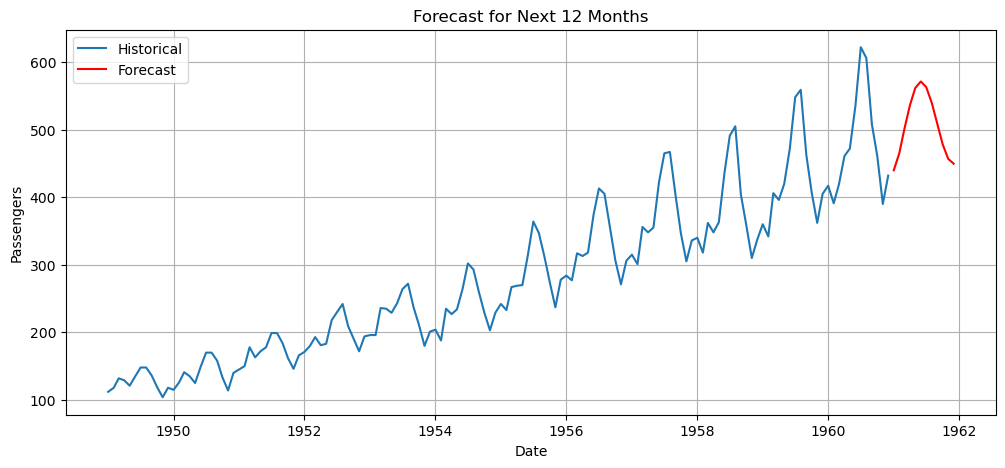

In [1]:
#This uses the ADF graph and differencing to determine the AR, MA and I values for ARIMA
#To Interpret the GRAPH of pacf and acf, spikes above 0 are the values we use for AR 
#The spikes below 0 are the values we use for MA
#The number of times we difference to have the p-value below 0.05 is the value for I
#This is what you use when comparing pacf and acf, the spikes for AR and MA must correspond on both pacf and acf plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load real-world monthly time series data
# We'll use the built-in 'AirPassengers' dataset (monthly airline passenger totals from 1949–1960)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Rename column for easier use
df.rename(columns={'Passengers': 'value'}, inplace=True)

# Plot the original time series
df['value'].plot(title='Monthly Air Passengers', figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

# Step 2: Check stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] > 0.05:
        print("Result: Non-stationary — Differencing needed")
    else:
        print("Result: Stationary")

print("=== ADF Test on Original Series ===")
adf_test(df['value'])

# Step 3: First-order differencing
df['diff'] = df['value'].diff()
#df['diff'] = df['diff'].diff()


# Drop NaNs after differencing
df_diff = df['diff'].dropna()

# Plot differenced series
df_diff.plot(title='First Order Differenced Series', figsize=(10, 5))
plt.show()

# ADF Test after differencing
print("\n=== ADF Test After First Differencing ===")
adf_test(df_diff)

# Step 4: Plot ACF and PACF to estimate q and p
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_diff, lags=20, ax=axes[0])
axes[0].set_title("ACF (Moving Average order q)")
plot_pacf(df_diff, lags=20, ax=axes[1])
axes[1].set_title("PACF (AutoRegression order p)")
plt.show()

# Based on PACF/ACF plots, we manually choose p=2 and q=2 (you can adjust as needed)
# Step 5: Fit ARIMA model (p, d, q) = (2, 1, 2)
model = ARIMA(df['value'], order=(2, 1, 2))
model_fit = model.fit()

#Print model summary
print(model_fit.summary())

##########################################
# print("Auto ARIMA VALUES")
# model = auto_arima(df['value'], 
#                    seasonal=True,    # Use True if you want seasonal ARIMA (SARIMA)
#                    trace=True,        # Shows what it's trying
#                    error_action='ignore',
#                    suppress_warnings=True)
# model_fit = model.fit(df['value'])

# print(model_fit.summary())
# print("Auto ARIMA END")
##########################################


# Step 6: Forecast the next 12 months
forecast = model_fit.forecast(steps=12)
print(f"Predicted Passengers next 12 months \n{forecast}")

# Create a date index for future months
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df['value'], label='Historical')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
#This is an example of SARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example data
data = pd.DataFrame({
    'sales': [100, 120, 130, 150, 170, 200, 220, 240],
    'ad_spend': [10, 15, 15, 20, 25, 30, 35, 40]
})
# Train-test split
train = data.iloc[:-2]
test = data.iloc[-2:]

# Fit SARIMAX
model = SARIMAX(
    train['sales'], 
    order=(1, 1, 1), 
    exog=train[['ad_spend']]
)#This doesn't disable seasonality meaning we're working with seasonal data resulting in SARIMAX
results = model.fit(method='bfgs') #The method parameter is the optimizer we're using, there multiple such as 'powell', 'nm', 'lbfgs'

# Forecast with exogenous variables
forecast = results.predict(
    start=len(train), 
    end=len(train)+len(test)-1,
    exog=test[['ad_spend']]
)
print(f'The forecast is \n{forecast}')


Optimization terminated successfully.
         Current function value: 2.380578
         Iterations: 42
         Function evaluations: 45
         Gradient evaluations: 45
The forecast is 
6    221.925315
7    247.182459
Name: predicted_mean, dtype: float64


In [3]:
#This is an example of ARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sample data
data = pd.DataFrame({
    'sales': [200, 220, 250, 300, 330, 360],
    'ad_spend': [10, 15, 20, 25, 30, 35]
})

# Train data
train_sales = data['sales']
train_exog = data[['ad_spend']]

# Future exogenous values for 3 steps ahead
future_exog = pd.DataFrame({'ad_spend': [40, 45, 50]})

# Fit ARIMAX model
model = SARIMAX(train_sales, exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)) #This disables seasonality resulting in ARIMAX
result = model.fit(disp=False)

# Forecast next 3 months
start = len(train_sales)
end = start + 2  # 3 steps ahead
forecast = result.predict(start=start, end=end, exog=future_exog)#exog must match the number of steps you're forecasting

print("Predicted sales for July to September:")
print(forecast)


Predicted sales for July to September:
6    394.388693
7    428.056628
8    461.687928
Name: predicted_mean, dtype: float64
